In [1]:
import pandas as pd
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

df = pd.read_csv('./data/classify_data.csv')
# df.drop(['season', 'day_time', 'weekday_index', 'weekend'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361346 entries, 0 to 361345
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   score          361346 non-null  float64
 1   hashtag        361346 non-null  object 
 2   lang           361346 non-null  object 
 3   tweet_lang     361346 non-null  object 
 4   time_zone      361346 non-null  object 
 5   month          361346 non-null  int64  
 6   hours          361346 non-null  int64  
 7   track_id       361346 non-null  object 
 8   season         361346 non-null  int64  
 9   day_time       361346 non-null  object 
 10  weekday_index  361346 non-null  int64  
 11  weekend        361346 non-null  bool   
dtypes: bool(1), float64(1), int64(4), object(6)
memory usage: 30.7+ MB


In [2]:
# track_to_label = pd.read_csv('./data/track_to_labels_dbscan.csv')
track_to_label = pd.read_csv('./data/track_to_labels_kmeans_2.csv')
track_to_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26911 entries, 0 to 26910
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   track_id  26911 non-null  object
 1   labels    26911 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 420.6+ KB


In [3]:
df = df.merge(track_to_label, on='track_id', how='left')
df.head()

,score,hashtag,lang,tweet_lang,time_zone,month,hours,track_id,season,day_time,weekday_index,weekend,labels
0,0.8,kiss92,en,en,Beijing,1,5,3Px454rzMHtIRc9R04QSlB,0,Wee hours(00:00 - 6:00),2,False,0
1,0.8,kiss92,en,en,Beijing,1,6,5eaD4UEbmcXZe0buNHOM64,0,Morning(6:00 - 12:00),2,False,1
2,0.8,kiss92,en,en,Beijing,1,6,75VOiyc0bT0VkFFQuKakgE,0,Morning(6:00 - 12:00),2,False,1
3,0.8,kiss92,en,en,Beijing,1,6,0Dy1Q2uUKII4asOHvexBn9,0,Morning(6:00 - 12:00),2,False,0
4,0.8,kiss92,en,en,Beijing,1,6,777VRhgQZ1L2c0RJnLlNI9,0,Morning(6:00 - 12:00),2,False,1


In [4]:
df = df.dropna()
df.labels.value_counts()

1    229765
0    131581
Name: labels, dtype: int64

In [5]:
# 去除离群点
df = df[df['labels'] != -1]
df.labels.value_counts()

1    229765
0    131581
Name: labels, dtype: int64

In [6]:
# # 创建交叉组合特征
# df['month_day_time'] = df['month'].astype(str) + '_' + df['day_time']
# df['day_time_hours'] = df['day_time'] + '_' + df['hours'].astype(str)

# 对分数score取平方、3次方
df['score_2'] = df['score'] ** 2
df['score_3'] = df['score'] ** 3

# 对情绪分数score进行分箱操作
labels = ['disgust', 'sadness', 'neutral', 'happiness', 'surprise']
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
df['mood'] = pd.cut(df['score'], labels=labels, bins = bins, include_lowest=True)
df['mood'] = df['mood'].astype('category')

df['mood_label'] = df['mood'].cat.codes
print(df[['mood', 'mood_label']])

bins = [0.0, 0.5, 1.0]
df['happy'] = pd.cut(df['score'], labels=[0, 1], bins = bins, include_lowest=True)

if (df['labels'] >= 2).sum() > 0:
    df.to_csv('./data/final_classify_data_5.csv', index = False)
else:
    df.to_csv('./data/final_classify_data_2.csv', index = False)

track_id = df.drop(['track_id'], inplace = True,  axis = 1)
df.info()

             mood  mood_label
0       happiness           3
1       happiness           3
2       happiness           3
3       happiness           3
4       happiness           3
...           ...         ...
361341    disgust           0
361342   surprise           4
361343    sadness           1
361344    sadness           1
361345    sadness           1

[361346 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 361346 entries, 0 to 361345
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   score          361346 non-null  float64 
 1   hashtag        361346 non-null  object  
 2   lang           361346 non-null  object  
 3   tweet_lang     361346 non-null  object  
 4   time_zone      361346 non-null  object  
 5   month          361346 non-null  int64   
 6   hours          361346 non-null  int64   
 7   season         361346 non-null  int64   
 8   day_time       361346 non-null  objec

In [7]:
df.drop(['mood'], inplace = True,  axis = 1)

In [8]:
# 对几个类别特别多的列采用二进制编码
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder

# # 二进制编码
# columns = ['hashtag', 'tweet_lang', 'time_zone', 'lang', 'month_day_time', 'day_time_hours']

# 不交叉组合
columns = ['hashtag', 'tweet_lang', 'time_zone', 'lang']

# # 特征衍生
columns += ['day_time']
for column in columns:
    encoder = LabelEncoder()
    df[column] = encoder.fit_transform(df[column])
    
print(df.info())
# 查看结果

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361346 entries, 0 to 361345
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   score          361346 non-null  float64 
 1   hashtag        361346 non-null  int64   
 2   lang           361346 non-null  int64   
 3   tweet_lang     361346 non-null  int64   
 4   time_zone      361346 non-null  int64   
 5   month          361346 non-null  int64   
 6   hours          361346 non-null  int64   
 7   season         361346 non-null  int64   
 8   day_time       361346 non-null  int64   
 9   weekday_index  361346 non-null  int64   
 10  weekend        361346 non-null  bool    
 11  labels         361346 non-null  int64   
 12  score_2        361346 non-null  float64 
 13  score_3        361346 non-null  float64 
 14  mood_label     361346 non-null  int8    
 15  happy          361346 non-null  category
dtypes: bool(1), category(1), float64(3), int64(10), int8(1)


In [9]:

X = df.drop(['labels'], axis = 1)
y = df['labels']
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361346 entries, 0 to 361345
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   score          361346 non-null  float64 
 1   hashtag        361346 non-null  int64   
 2   lang           361346 non-null  int64   
 3   tweet_lang     361346 non-null  int64   
 4   time_zone      361346 non-null  int64   
 5   month          361346 non-null  int64   
 6   hours          361346 non-null  int64   
 7   season         361346 non-null  int64   
 8   day_time       361346 non-null  int64   
 9   weekday_index  361346 non-null  int64   
 10  weekend        361346 non-null  bool    
 11  score_2        361346 non-null  float64 
 12  score_3        361346 non-null  float64 
 13  mood_label     361346 non-null  int8    
 14  happy          361346 non-null  category
dtypes: bool(1), category(1), float64(3), int64(9), int8(1)
memory usage: 36.9 MB
None


In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = MinMaxScaler().fit_transform(X)
X = StandardScaler().fit_transform(X)
y = np.array(y)
print(X, '\n', y)

[[ 0.90456012 -0.43526774 -0.50107684 ...  1.1266475   0.67223875
   0.74015667]
 [ 0.90456012 -0.43526774 -0.50107684 ...  1.1266475   0.67223875
   0.74015667]
 [ 0.90456012 -0.43526774 -0.50107684 ...  1.1266475   0.67223875
   0.74015667]
 ...
 [-0.74829412 -1.73401162 -0.50107684 ... -1.13846628 -0.80251746
  -1.35106531]
 [-0.74829412 -1.92419573 -0.50107684 ... -1.13846628 -0.80251746
  -1.35106531]
 [-0.74829412 -1.68010917 -0.50107684 ... -1.13846628 -0.80251746
  -1.35106531]] 
 [0 1 1 ... 1 1 1]


### 分类
#### 常用机器学习模型

In [ ]:

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import time
from sklearn.utils.class_weight import compute_class_weight    

# 降维
n_components = np.arange(2, 8)

# 假设你有五个类别，其中某些类别的样本量远少于其他
classes = np.array([0, 1, 2, 3, 4])
class_weights = compute_class_weight('balanced', classes=classes, y=y)
weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(weight_dict)

# 定义模型
models = {
    'LogisticRegression': LogisticRegression(C=0.1, max_iter=5000, class_weight=weight_dict),
    'LightGBM': lgb.LGBMClassifier(n_estimators=10, random_state=42, force_row_wise=True,  class_weight=weight_dict),
    'RandomForest': RandomForestClassifier(n_estimators=10, random_state=42,  class_weight=weight_dict)
}

# # 定义模型
# models = {
#     'LogisticRegression': LogisticRegression(C=0.1, max_iter=5000),
#     'LightGBM': lgb.LGBMClassifier(n_estimators=10, random_state=42, force_row_wise=True),
#     'RandomForest': RandomForestClassifier(n_estimators=10, random_state=42)
# }

scores = {}
for name, model in models.items():
    for n_component in n_components:
        X_pca = PCA(n_components = n_component).fit_transform(X_resampled_norm_and_one, y)
        X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f'{name} y_pred 0 的个数为 为{(y_pred == 0).sum()}, 1的个数为{(y_pred == 1).sum()},2的个数为：{(y_pred == 2).sum()}, 3的个数为:{(y_pred == 3).sum()}, 4的个数为：{(y_pred==4).sum()}')
        accuracy = accuracy_score(y_test, y_pred)
        print(f'{name} 降维为{n_component}的准确率为{accuracy}')
        if name not in scores:
            scores[name] = []
        scores[name].append(accuracy)

In [ ]:
import matplotlib.pyplot as plt
# 创建图和轴
fig, ax = plt.subplots(figsize=(12, 8))

# 循环遍历scores字典中的每个模型，绘制其准确率折线图
for model_name, accuracies in scores.items():
    ax.plot(n_components, accuracies, label=model_name)

# 设置图例
ax.legend()

# 添加标题和轴标签
ax.set_title('Model Accuracy by Number of PCA Components')
ax.set_xlabel('Number of PCA Components')
ax.set_ylabel('Accuracy')

# 显示图形
plt.show()

In [ ]:
# 因此降为7维进行交叉验证
from sklearn.decomposition import PCA

X_pca = PCA(n_components = 9).fit_transform(X_resampled_norm_and_one)

In [ ]:
# LDA降维
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X_lda = LDA(n_components = 3).fit_transform(X_resampled_norm_and_one, y)

In [ ]:
X_lda

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LogisticRegression
import time
from sklearn.utils.class_weight import compute_class_weight 

# 定义模型

# # 有五个类别，其中某些类别的样本量远少于其他
# classes = np.array([0, 1, 2, 3, 4])
# class_weights = compute_class_weight('balanced', classes=classes, y=y)
# weight_dict = {i: weight for i, weight in enumerate(class_weights)}
# print(weight_dict)

# models = {
#     'LogisticRegression': LogisticRegression(C=0.1, max_iter=10000, class_weight=weight_dict),
#     'LightGBM': lgb.LGBMClassifier(n_estimators=10, random_state=42, force_row_wise=True,  class_weight=weight_dict),
#     'RandomForest': RandomForestClassifier(n_estimators=10, random_state=42,  class_weight=weight_dict)
# }

models = {
    'LogisticRegression': LogisticRegression(C=0.1, max_iter=10000),
    'LightGBM': lgb.LGBMClassifier(n_estimators=10, random_state=42, force_row_wise=True),
    'RandomForest': RandomForestClassifier(n_estimators=10, random_state=42)
}

## 去除噪声，平衡样本，32 33 （未衍生）
## 去除噪声，未平衡样本，41、43、43 （这里预测值有偏向）

# 定义评估指标
num_classes = len(set(y))
print(num_classes)

scoring = []
if num_classes == 2:
    scoring = ['accuracy', 'precision', 'recall', 'f1']
elif num_classes > 2:
    scoring = ['accuracy', 'f1_micro', 'f1_macro', 'f1_weighted']
else:
    print(f'Error num_classes of {num_classes}')

# 使用Stratified K-Fold进行交叉验证
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 训练模型并评估
results = {name: [] for name in models}
for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    start_time = time.time()
    for score_name in scoring:
        score = cross_val_score(model, X_resampled_norm_and_one, y, scoring=score_name, cv=cv, n_jobs=-1)
        results[model_name].append((score.mean(), score.std()))
    end_time = time.time()
    print(f'{model_name}运行时间为：{end_time - start_time}')

# 输出结果
for model_name, model_scores in results.items():
    print(f"\nResults for {model_name}:")
    for i, score_name in enumerate(scoring):
        mean, std = model_scores[i]
        print(f"{score_name}: {100 * mean:.2f}±{100 * std:.2f}")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 参数网格
param_grid_lr = {
    'C': [1],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

# 创建模型
logistic_model = LogisticRegression(max_iter=5000)

# 创建 GridSearchCV 对象
grid_search_lr = GridSearchCV(estimator=logistic_model, param_grid=param_grid_lr, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# 加载数据
grid_search_lr.fit(X_resampled, y_resampled)

# 获取最佳参数和最佳分数
best_parameters = grid_search_lr.best_params_
best_score = grid_search_lr.best_score_

# 打印结果
print("Best parameters:", best_parameters)
print("Best score:", best_score)

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# 参数网格
param_grid_lr = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 20, 40],
    'min_samples_split': [5, 10],
    'criterion': ['gini', 'entropy']
}

# 创建模型
rf = RandomForestClassifier(random_state=42)

# 创建 GridSearchCV 对象
grid_search_lr = GridSearchCV(estimator=rf, param_grid=param_grid_lr, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)

# 加载数据
grid_search_lr.fit(X, y)

# 获取最佳参数和最佳分数
best_parameters = grid_search_lr.best_params_
best_score = grid_search_lr.best_score_

# 打印结果
print("Best parameters:", best_parameters)
print("Best score:", best_score)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  33.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  54.2s
[CV] END criterion=gini, max_depth=40, max_features=log2, min_samples_split=5, n_estimators=200; total time= 1.2min
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  44.2s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=50; total time=  10.4s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=10, n_estimators=100; total time=  20.9s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=100; total time=  27.4s
[CV] END criterion=gini, max_depth=40, max_features=sqrt, min_samples_split=5, n_estimators=100; total time=  34.7s
[CV

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import numpy as np
from sklearn.utils.class_weight import compute_class_weight 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_classes, dim_feedforward=64, num_layers=5):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.embedding = nn.Linear(input_dim, dim_feedforward)
        
        # 添加 Batch Normalization 层
        self.batch_norm = nn.BatchNorm1d(dim_feedforward)
        
        # 初始化 Transformer 编码器层
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_feedforward, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Dropout 层
        self.dropout = nn.Dropout(0.5)
        
        # 输出层
        self.output_layer = nn.Linear(dim_feedforward, num_classes)
        
        # ReLU 激活函数
        self.relu = nn.ReLU()

    def forward(self, src):
        # src shape: (batch_size, input_dim)
        src = self.embedding(src)  # (batch_size, dim_feedforward)
        
        # 应用批归一化
        src = self.batch_norm(src)
        
        # 应用 ReLU 激活函数
        src = self.relu(src)
        
        src = src.unsqueeze(1)  # (batch_size, 1, dim_feedforward) - Transformer expects seq_len, batch, dim
        output = self.transformer_encoder(src)
        output = output.squeeze(1)  # (batch_size, dim_feedforward)
        
        # 应用 Dropout
        output = self.dropout(output)
        
        output = self.output_layer(output)
        
        return output



model = TransformerModel(input_dim=X.shape[1], num_heads=4, num_classes= len(set(y))).to(device)
# 有五个类别，其中某些类别的样本量远少于其他
# classes = np.array([0, 1, 2, 3, 4])

classes = np.array([0, 1])
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights = torch.FloatTensor(class_weights).cuda()  # 如果你在使用GPU
print(class_weights)

# if (y > 2).sum() == 0:
#     criterion = nn.BCELoss().to(device)
# else:
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
# criterion = nn.CrossEntropyLoss().to(device)
print(criterion)

# lr = 0.0001 准确率0.64
# lr = 0.00005, 65.03
optimizer = optim.Adam(model.parameters(), lr=1e-6)

tensor([1.3731, 0.7863], device='cuda:0')
CrossEntropyLoss()


In [24]:
# 划分数据集
X_tensor = torch.tensor(X, dtype=torch.float32)
# 转换标签数据类型
y_tensor = torch.tensor(y, dtype=torch.long)  # 确保y是正确的形状

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# DataLoader
batch_size = 256
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# 训练和测试
train_loss, test_loss = [], []
train_acc, test_acc = [], []
epochs = 100
for epoch in range(epochs):  # 训练5个epoch
    print(f"Epoch {epoch+1}")
    model.train()
    total_loss = 0
    total_num, correct = 0, 0
    s = {0:0, 1:0, 2:0, 3:0, 4:0}
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # 计算准确率
        _, predicted = torch.max(output.data, 1)  # 获取每个样本的预测类别
        correct += (predicted == target).sum().item()  # 计算正确预测的数量
        total_num += target.size(0)  # 计算准确率
        
        for i in range(5):
            s[i] += (predicted == i).sum()
        
    for i in range(5):
        print(f"训练集预测为{i}的样本数为：{s[i]}")
    avg_train_loss = total_loss / len(train_loader)
    acc = correct / total_num * 100
    train_loss.append(avg_train_loss)
    train_acc.append(acc)
    print(f"Average Training Loss: {avg_train_loss}, Accuracy: {acc:.2f}%")
          
    model.eval()
    total_loss = 0
    total_num, correct = 0, 0
    s = {0:0, 1:0, 2:0, 3:0, 4:0}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(output.data, 1)  # 获取每个样本的预测类别
            correct += (predicted == target).sum().item()  # 计算正确预测的数量
            total_num += target.size(0)  # 计算准确率
            
            for i in range(5):
                s[i] += (predicted == i).sum()
        
    for i in range(5):
        print(f"测试集预测为{i}的样本数为：{s[i]}")
    avg_test_loss = total_loss / len(test_loader)
    acc = correct / total_num * 100
    test_loss.append(avg_test_loss)
    test_acc.append(acc)
    print(f"Test Loss: {avg_test_loss}, Accuracy: {acc:.2f}%")
    
torch.save(model, './models/transformer_balance_2.pth')

Epoch 1
训练集预测为0的样本数为：148602
训练集预测为1的样本数为：140474
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.7666056824996408, Accuracy: 49.58%
测试集预测为0的样本数为：40352
测试集预测为1的样本数为：31918
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.6959884594270281, Accuracy: 48.71%
Epoch 2
训练集预测为0的样本数为：146746
训练集预测为1的样本数为：142330
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.715720335044692, Accuracy: 50.15%
测试集预测为0的样本数为：43445
测试集预测为1的样本数为：28825
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.6932342448419901, Accuracy: 48.17%
Epoch 3
训练集预测为0的样本数为：148050
训练集预测为1的样本数为：141026
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.7058897526390785, Accuracy: 50.03%
测试集预测为0的样本数为：40303
测试集预测为1的样本数为：31967
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.6923620877754562, Accuracy: 49.63%
Epoch 4
训练集预测为0的样本数为：146587
训练集预测为1的样本数为：142489
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.7014899500175915, Accuracy: 50.

训练集预测为0的样本数为：123763
训练集预测为1的样本数为：165313
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6906094247788455, Accuracy: 54.05%
测试集预测为0的样本数为：27963
测试集预测为1的样本数为：44307
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.689565026928595, Accuracy: 55.69%
Epoch 31
训练集预测为0的样本数为：124150
训练集预测为1的样本数为：164926
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6908222001738253, Accuracy: 53.81%
测试集预测为0的样本数为：27077
测试集预测为1的样本数为：45193
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.6895305851323024, Accuracy: 56.02%
Epoch 32
训练集预测为0的样本数为：123413
训练集预测为1的样本数为：165663
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6908469425893463, Accuracy: 54.00%
测试集预测为0的样本数为：23870
测试集预测为1的样本数为：48400
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.689453333300331, Accuracy: 57.27%
Epoch 33
训练集预测为0的样本数为：121697
训练集预测为1的样本数为：167379
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6905485760321659, Accuracy: 54.15%
测试

训练集预测为0的样本数为：108029
训练集预测为1的样本数为：181047
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6888124011259164, Accuracy: 55.83%
测试集预测为0的样本数为：19733
测试集预测为1的样本数为：52537
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.688149510971649, Accuracy: 58.89%
Epoch 60
训练集预测为0的样本数为：109176
训练集预测为1的样本数为：179900
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6886132188075411, Accuracy: 55.83%
测试集预测为0的样本数为：16654
测试集预测为1的样本数为：55616
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.6881346957422398, Accuracy: 60.01%
Epoch 61
训练集预测为0的样本数为：108133
训练集预测为1的样本数为：180943
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6888026727511819, Accuracy: 55.87%
测试集预测为0的样本数为：21674
测试集预测为1的样本数为：50596
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.6879943175366405, Accuracy: 58.10%
Epoch 62
训练集预测为0的样本数为：107884
训练集预测为1的样本数为：181192
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6886671419164776, Accuracy: 55.94%
测

训练集预测为0的样本数为：102826
训练集预测为1的样本数为：186250
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6874467685159329, Accuracy: 56.47%
测试集预测为0的样本数为：23117
测试集预测为1的样本数为：49153
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.6867960632479233, Accuracy: 57.80%
Epoch 89
训练集预测为0的样本数为：105319
训练集预测为1的样本数为：183757
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6872762524976139, Accuracy: 56.28%
测试集预测为0的样本数为：19387
测试集预测为1的样本数为：52883
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.6868325389737375, Accuracy: 59.05%
Epoch 90
训练集预测为0的样本数为：99976
训练集预测为1的样本数为：189100
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.6872046716445315, Accuracy: 56.90%
测试集预测为0的样本数为：23761
测试集预测为1的样本数为：48509
测试集预测为2的样本数为：0
测试集预测为3的样本数为：0
测试集预测为4的样本数为：0
Test Loss: 0.6867245623163958, Accuracy: 57.46%
Epoch 91
训练集预测为0的样本数为：102516
训练集预测为1的样本数为：186560
训练集预测为2的样本数为：0
训练集预测为3的样本数为：0
训练集预测为4的样本数为：0
Average Training Loss: 0.68721530885823, Accuracy: 56.60%
测试集

loss 0.646, train acc 0.646, test acc 0.646
3899.3 examples/sec on cuda:0


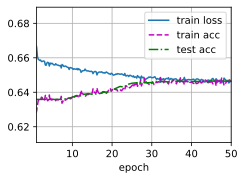

In [17]:
import torch
from torch import nn
from d2l import torch as d2l
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

d2l.plt.rcParams['figure.figsize'] = (20, 12)

X_tensor = torch.tensor(X, dtype=torch.float32)
# 转换标签数据类型
y_tensor = torch.tensor(y, dtype=torch.long)  # 确保y是正确的形状

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42, stratify=y)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

lr, num_epochs = 0.01, 50
d2l.train_ch6(model, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

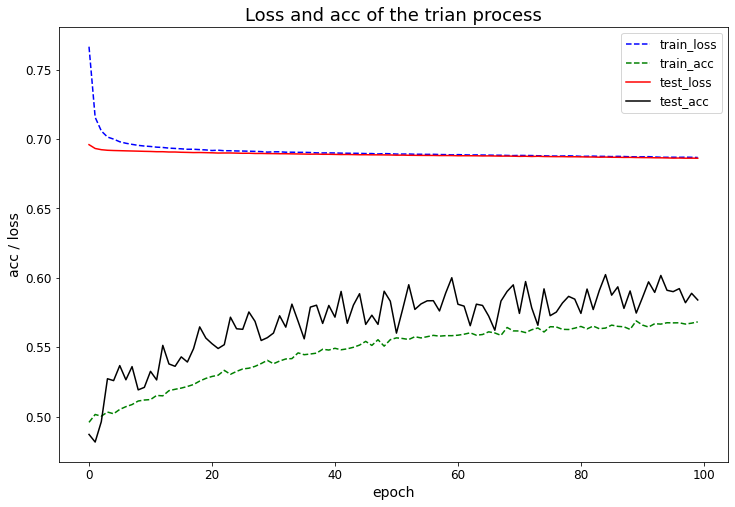

In [25]:
import matplotlib.pyplot as plt
# 设置全局图表大小
plt.rc('figure', figsize=(12, 8))
plt.rc('axes', titlesize=18)  # 设置轴标题的字体大小
plt.rc('axes', labelsize=14)  # 设置轴标签的字体大小
plt.rc('xtick', labelsize=12)  # 设置x轴刻度标签的字体大小
plt.rc('ytick', labelsize=12)  # 设置y轴刻度标签的字体大小
plt.rc('legend', fontsize=12)  # 设置图例的字体大小

plt.figure()
plt.title('Loss and acc of the trian process')
plt.plot(range(epochs), train_loss, 'b--', label='train_loss')
plt.plot(range(epochs), [x / 100 for x in train_acc], 'g--', label = 'train_acc')
plt.plot(range(epochs), test_loss, 'r', label = 'test_loss')
plt.plot(range(epochs), [x / 100 for x in test_acc], 'black', label = 'test_acc')
plt.xlabel('epoch')
plt.ylabel('acc / loss')
plt.legend(loc='best')
plt.show()